In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
# all modules/dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
data_dir = "data_transfer"

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#data transformation
data_transforms = {
   'train': transforms.Compose([
       transforms.Resize(size=(224,224)),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'validation': transforms.Compose([
       transforms.Resize(size=(224,224)),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}


In [3]:
image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(data_dir, x),
       transform=data_transforms[x]
   )
   for x in ['train', 'validation']
}

dataloaders = {
   x: torch.utils.data.DataLoader(
       image_datasets[x], batch_size=32,
       shuffle=True, num_workers=4
   )
   for x in ['train', 'validation']
}

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

print(dataset_sizes)
class_names = image_datasets['train'].classes



{'train': 777, 'validation': 256}


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
print(device)

cpu


In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [8]:
vgg_based = torchvision.models.vgg19(pretrained=True)

## freeze the layers
for param in vgg_based.parameters():
    param.requires_grad = False

# Modify the last layer
number_features = vgg_based.classifier[6].in_features
features = list(vgg_based.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(class_names))])
vgg_based.classifier = torch.nn.Sequential(*features)

vgg_based = vgg_based.to(device)

print(vgg_based)

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(vgg_based.parameters(), lr=0.001, momentum=0.9)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} truth: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = std * img + mean
                ax.imshow(img)
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
vgg_based = train_model(vgg_based, criterion, optimizer_ft,exp_lr_scheduler, num_epochs=25)



Epoch 0/24
----------
train Loss: 0.6474 Acc: 0.6379
validation Loss: 0.5776 Acc: 0.6944

Epoch 1/24
----------
train Loss: 0.6189 Acc: 0.6737
validation Loss: 0.6071 Acc: 0.6688

Epoch 2/24
----------
train Loss: 0.6262 Acc: 0.6691
validation Loss: 0.5578 Acc: 0.7144

Epoch 3/24
----------
train Loss: 0.6217 Acc: 0.6800
validation Loss: 0.5527 Acc: 0.7194

Epoch 4/24
----------
train Loss: 0.6096 Acc: 0.6832
validation Loss: 0.5443 Acc: 0.7225

Epoch 5/24
----------
train Loss: 0.5991 Acc: 0.6847
validation Loss: 0.5516 Acc: 0.7063

Epoch 6/24
----------
train Loss: 0.5807 Acc: 0.6982
validation Loss: 0.5543 Acc: 0.7100

Epoch 7/24
----------
train Loss: 0.5796 Acc: 0.7021
validation Loss: 0.5454 Acc: 0.7144

Epoch 8/24
----------
train Loss: 0.5682 Acc: 0.7010
validation Loss: 0.5516 Acc: 0.7156

Epoch 9/24
----------
train Loss: 0.5714 Acc: 0.6999
validation Loss: 0.5470 Acc: 0.7200

Epoch 10/24
----------
train Loss: 0.5646 Acc: 0.7069
validation Loss: 0.5448 Acc: 0.7206

Epoch 11/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


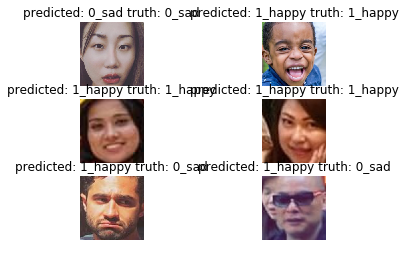

In [0]:
visualize_model(vgg_based)

plt.show()


In [0]:
torch.save(vgg_based.state_dict(), 'model_vgg19_transfer_v2.pt')

In [0]:
model_2 = torchvision.models.vgg19(pretrained=True)

for param in model_2.parameters():
    param.requires_grad = False


num_ftrs = vgg_based.classifier[6].in_features
print(num_ftrs)

features = list(model_2.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(num_ftrs, len(class_names))])
model_2.classifier = torch.nn.Sequential(*features)

model_2 = model_2.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)




4096


In [0]:
vgg_based_2 = train_model(model_2, criterion, optimizer_ft,exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6702 Acc: 0.5909
validation Loss: 0.6248 Acc: 0.6797

Epoch 1/24
----------
train Loss: 0.6171 Acc: 0.6818
validation Loss: 0.5734 Acc: 0.6719

Epoch 2/24
----------
train Loss: 0.5698 Acc: 0.7150
validation Loss: 0.5737 Acc: 0.6680

Epoch 3/24
----------
train Loss: 0.5451 Acc: 0.7052
validation Loss: 0.5082 Acc: 0.7773

Epoch 4/24
----------
train Loss: 0.5604 Acc: 0.7052
validation Loss: 0.5078 Acc: 0.7500

Epoch 5/24
----------
train Loss: 0.5888 Acc: 0.7027
validation Loss: 0.4941 Acc: 0.7656

Epoch 6/24
----------
train Loss: 0.5476 Acc: 0.7211
validation Loss: 0.5082 Acc: 0.7695

Epoch 7/24
----------
train Loss: 0.5193 Acc: 0.7531
validation Loss: 0.5096 Acc: 0.7617

Epoch 8/24
----------
train Loss: 0.5132 Acc: 0.7494
validation Loss: 0.5078 Acc: 0.7578

Epoch 9/24
----------
train Loss: 0.5264 Acc: 0.7371
validation Loss: 0.5079 Acc: 0.7578

Epoch 10/24
----------
train Loss: 0.5383 Acc: 0.7482
validation Loss: 0.5102 Acc: 0.7539

Epoch 11/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


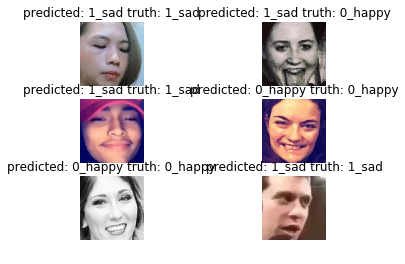

In [0]:
visualize_model(model_2)

plt.show()
